# 주의!! 해당 과제는 꼭!!! Colab환경에서 수행해 주세요~!!!

# 스위스 롤을 만들어보자!

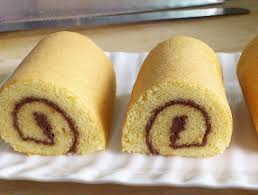

이 예제를 참고해서 밑에 있는 과제를 수행해 주세요~~

## 1. Data Preparation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_swiss_roll
import torch
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from base64 import b64encode
from PIL import Image, ImageFilter

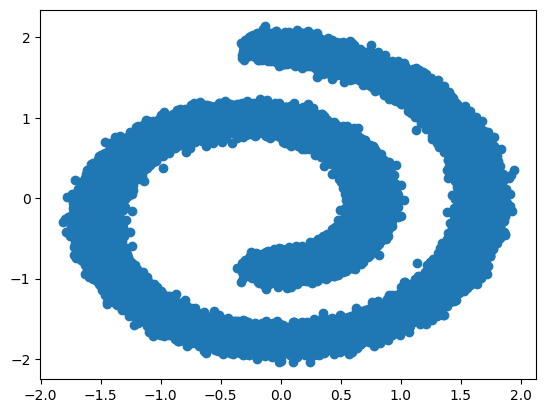

In [3]:
x, _ = make_swiss_roll(n_samples=100000, noise=0.5) # Swiss roll 분포에서 10만개의 sample 추출

# 2차원 Swiss roll Visualization
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std() # normalize

plt.scatter(x[:, 0], x[:, 1]);

## 2. Preprocessing for Learning

In [4]:
X = torch.tensor(x, dtype=torch.float32) # 학습을 위해 Torch Tensor 형태로 변경

### 2-1. Diffusion Hyperparameter

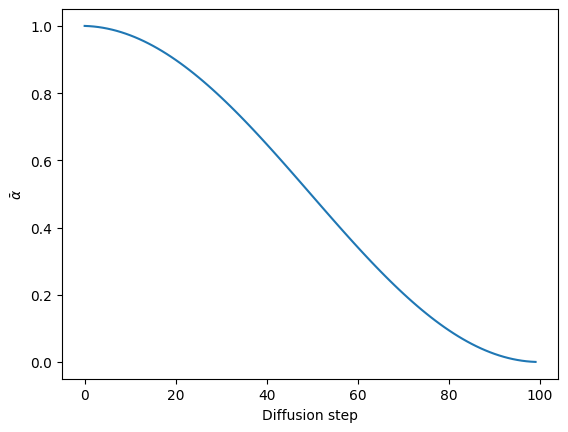

In [5]:

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
diffusion_steps = 100
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

### 2-2. Image에 Noise를 더하자

In [6]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

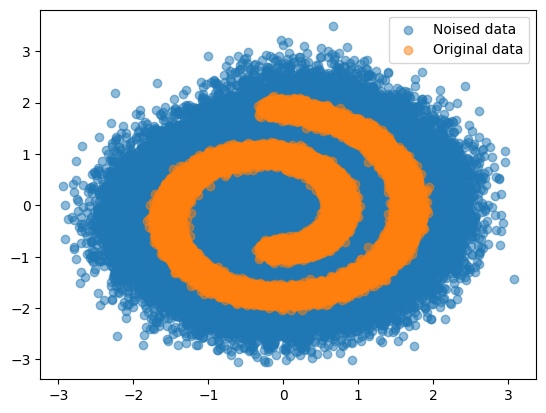

In [7]:
# 30 step 만큼 Diffusion을 진행 했을 때의 Data
noiselevel = 30

noised, eps = noise(X, torch.full([len(X), 1], fill_value=noiselevel))
plt.scatter(noised[:, 0], noised[:, 1], marker="o", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show()

### 2-3. Noise를 빼서 다시 원래대로 돌리면?

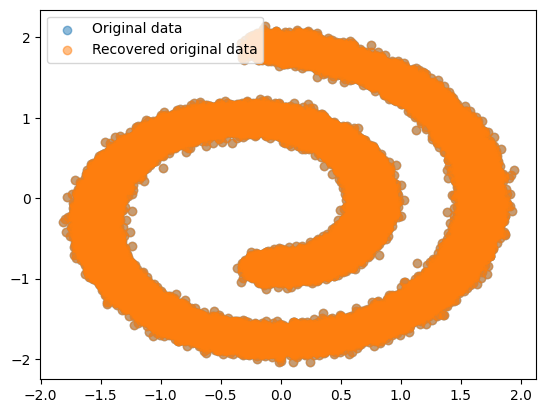

In [8]:
# 위의 30 step에서 원래 데이터로 복구한다면 ?
denoised = 1 / torch.sqrt(baralphas[noiselevel]) * (noised - torch.sqrt(1 - baralphas[noiselevel]) * eps)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(denoised[:, 0], denoised[:, 1], marker="o", alpha=0.5)
plt.legend(["Original data", "Recovered original data"])
plt.show()

### 2-4. Diffusion이 어떤식으로 일어나는지 확인해 볼까요?

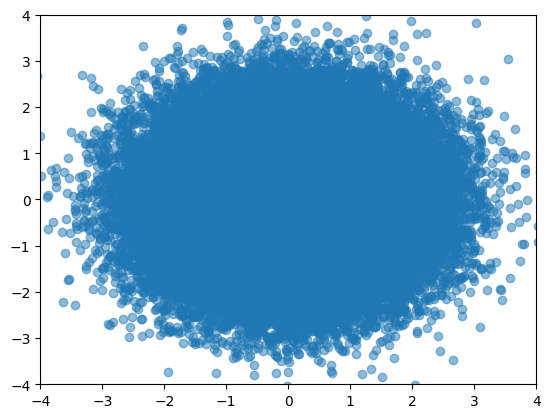

In [9]:
# 초기화
vis_X = X.clone()  # 시각화를 위한 복사본 생성

# 애니메이션 그리기
fig, ax = plt.subplots()
scat_noised = ax.scatter([], [], marker="o", alpha=0.5)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
# 초기화 함수
def init():
    scat_noised.set_offsets(np.empty((0, 2)))  # 0x2 형태의 빈 배열 전달
    return scat_noised,

# 각 프레임을 업데이트하는 함수
def update(frame):
    t = torch.full([len(vis_X), 1], fill_value=frame)
    noised, eps = noise(vis_X, t)
    scat_noised.set_offsets(noised.numpy())  # numpy로 변환하여 그래프에 추가
    return scat_noised,

# 애니메이션 생성
ani = FuncAnimation(fig, update, frames=np.arange(0, diffusion_steps), init_func=init, blit=True)

# 애니메이션 저장 (또는 화면에 표시)
ani.save("swiss_roll_noise_animation.gif", writer='imagemagick', fps=10);

In [10]:
# 애니메이션을 실행하고 싶으면 다음 줄을 실행하세요.
gif = open('/content/swiss_roll_noise_animation.gif','rb').read()  # gif 파일 경로로 변경
data_url = "data:image/gif;base64," + b64encode(gif).decode()  # MIME 타입을 'image/gif'로 변경
HTML("""
<img src="%s" width=400>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

## 3. Learning

### 3-1. Model Architecture
간단한 MLP로 구현

In [11]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

In [12]:
model = DiffusionModel(nfeatures=2, nblocks=6)

device = "cuda" # 꼭 colab runtime을 GPU로 바꿔주세요~
model = model.to(device)

model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-5): 6 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

### 3-2. Fire!!

In [13]:
import torch.optim as optim

nepochs = 500
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 0.9386533498764038
Epoch 1 loss = 0.7784980535507202
Epoch 2 loss = 0.6292669773101807
Epoch 3 loss = 0.519805908203125
Epoch 4 loss = 0.5093998908996582
Epoch 5 loss = 0.4924706220626831
Epoch 6 loss = 0.49251458048820496
Epoch 7 loss = 0.4831520617008209
Epoch 8 loss = 0.4786549210548401
Epoch 9 loss = 0.4782620966434479
Epoch 10 loss = 0.47758257389068604
Epoch 11 loss = 0.4670025110244751
Epoch 12 loss = 0.4687112867832184
Epoch 13 loss = 0.47252047061920166
Epoch 14 loss = 0.46487051248550415
Epoch 15 loss = 0.4620339572429657
Epoch 16 loss = 0.4590480923652649
Epoch 17 loss = 0.4611356258392334
Epoch 18 loss = 0.46162059903144836
Epoch 19 loss = 0.4616260528564453
Epoch 20 loss = 0.45622768998146057
Epoch 21 loss = 0.4534517228603363
Epoch 22 loss = 0.45262160897254944
Epoch 23 loss = 0.45524832606315613
Epoch 24 loss = 0.44946372509002686
Epoch 25 loss = 0.44847729802131653
Epoch 26 loss = 0.45348843932151794
Epoch 27 loss = 0.4464792311191559
Epoch 28 loss = 0.44

### 3-3. Inference 시작

In [14]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise) # Denoising을 위한 수식
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

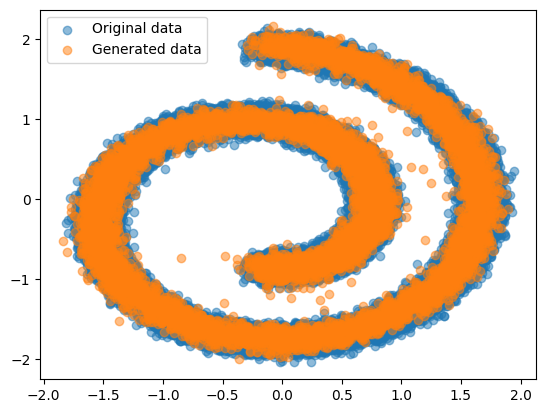

In [15]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2) # 10000개의 2차원 가우시안을 이용해서 Denoising 진행
Xgen = Xgen.cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="o", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()

### 3-4. Visualization

In [ ]:
import matplotlib.animation as animation

def draw_frame(i):
    plt.clf()
    Xvis = Xgen_hist[i].cpu()
    fig = plt.scatter(Xvis[:, 0], Xvis[:, 1], marker="o", animated=True)
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    return fig,

fig = plt.figure()
anim = animation.FuncAnimation(fig, draw_frame, frames=diffusion_steps, interval=20, blit=True)
anim.save('swissroll_generation.mp4', fps=10)

In [ ]:
mp4 = open('/content/swissroll_generation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


# 이제 이모티콘 분포를 만들어 보자!! 과제 시작!

<img src = "https://drive.google.com/uc?id=18Sa0a5ms2Nv9F7swkdPyaxPuGC0ckosf" height = 300 width = 300>

## Dataset 만들기

In [16]:
!gdown https://drive.google.com/uc?id=18Sa0a5ms2Nv9F7swkdPyaxPuGC0ckosf

Downloading...
From: https://drive.google.com/uc?id=18Sa0a5ms2Nv9F7swkdPyaxPuGC0ckosf
To: /content/img3.png
100% 6.32k/6.32k [00:00<00:00, 27.7MB/s]


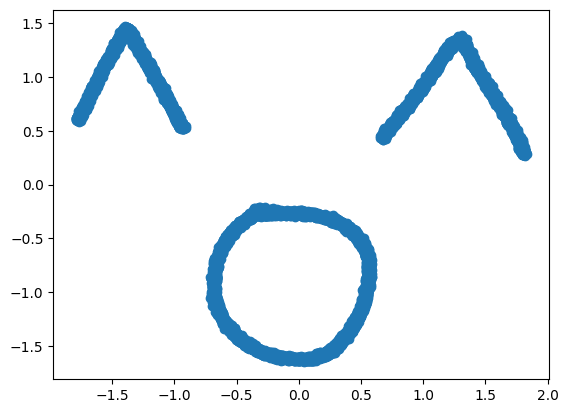

In [17]:
def array_to_toy_dataset(array, n_samples):
    """
    Create dataset from ditribution 2d array
    """
    # Create a flat copy of the array
    flat = array.flatten()

    # Then, sample an index from the 1D array with the
    # probability distribution from the original array
    sample_index = np.random.choice(a=flat.size, p=flat, size=n_samples)

    # Take this index and adjust it so it matches the original array
    adjusted_index = np.unravel_index(sample_index, array.shape)
    data = np.array([[x, y] for x, y in zip(adjusted_index[1], array.shape[1] - adjusted_index[0])])
    return data


def image_to_toy_dataset(path, n_samples, blur_radius=1):
    img = Image.open(path)
    img = img.convert('RGB')
    img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    img = img.convert('L')
    img = 255 - np.asarray(img)
    array = img / img.sum()
    return array_to_toy_dataset(array, n_samples)

data = image_to_toy_dataset("/content/img3.png", 15000, blur_radius=1) # 이모티콘 분포에서 15000개 데이터 샘플링
x = (data - data.mean(axis=0)) / data.std(axis=0)
plt.scatter(x[:,0], x[:,1])
X = torch.tensor(x, dtype=torch.float32) # 학습을 위해 Torch Tensor 형태로 변경

## 하이퍼파라미터

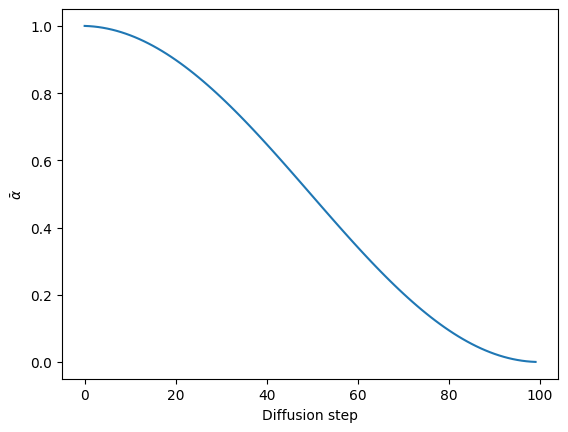

In [18]:

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
diffusion_steps = 100
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

## Noise를 더해보자

<img src = "https://drive.google.com/uc?id=1fPQUrUM66SQoqQ5C21r0NEQuGVMP3nJh" height = 300 width = 900>

In [ ]:
# @title Forward Process를 구현해보자
# @markdown 위 Figure에서 빨간색 부분과 파란색 부분을 구현해 주세요!
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)

    Red = baralphas[t]**1/2 # @param {"type":"raw"}
    Blue = (betas[t]) ** 1/2 # @param {"type":"raw"}
    noised = (Red).repeat(1, Xbatch.shape[1]) * Xbatch + (Blue).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps
# @markdown Hint: $\bar{\alpha}_t$ 는baralphas라는 array에 t번째 index를 가져오면 된답니다~~
# @markdown Root는 어떻게 적용하면 될까요?




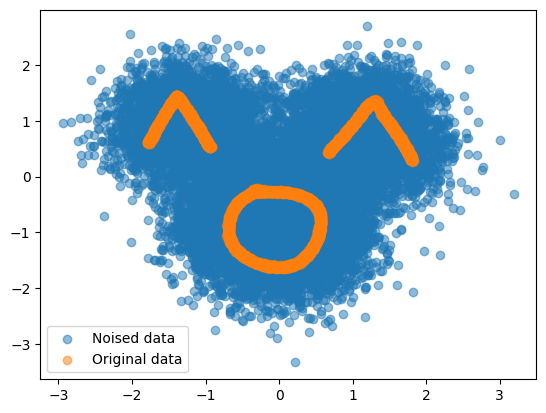

In [19]:
# 30 step 만큼 Diffusion을 진행 했을 때의 Data
noiselevel = 30

noised, eps = noise(X, torch.full([len(X), 1], fill_value=noiselevel))
plt.scatter(noised[:, 0], noised[:, 1], marker="o", alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.legend(["Noised data", "Original data"])
plt.show()

### Diffusion forward 과정을 Visualization 해봐요~

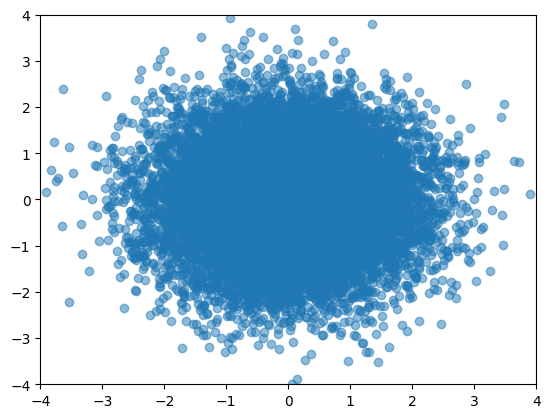

In [20]:
# 초기화
vis_X = X.clone()  # 시각화를 위한 복사본 생성

# 애니메이션 그리기
fig, ax = plt.subplots()
scat_noised = ax.scatter([], [], marker="o", alpha=0.5)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
# 초기화 함수
def init():
    scat_noised.set_offsets(np.empty((0, 2)))  # 0x2 형태의 빈 배열 전달
    return scat_noised,

# 각 프레임을 업데이트하는 함수
def update(frame):
    t = torch.full([len(vis_X), 1], fill_value=frame)
    noised, eps = noise(vis_X, t)
    scat_noised.set_offsets(noised.numpy())  # numpy로 변환하여 그래프에 추가
    return scat_noised,

# 애니메이션 생성
ani = FuncAnimation(fig, update, frames=np.arange(0, diffusion_steps), init_func=init, blit=True)

# 애니메이션 저장 (또는 화면에 표시)
ani.save("emoji_noise_animation.gif", writer='imagemagick', fps=10);

In [21]:
# 애니메이션을 실행하고 싶으면 다음 줄을 실행하세요.
gif = open('/content/emoji_noise_animation.gif','rb').read()  # gif 파일 경로로 변경
data_url = "data:image/gif;base64," + b64encode(gif).decode()  # MIME 타입을 'image/gif'로 변경
HTML("""
<img src="%s" width=400>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

## 모델 구현

In [22]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val
model = DiffusionModel(nfeatures=2, nblocks=6)

device = "cuda" # 꼭 colab runtime을 GPU로 바꿔주세요~
model = model.to(device)

model

DiffusionModel(
  (inblock): Linear(in_features=3, out_features=64, bias=True)
  (midblocks): ModuleList(
    (0-5): 6 x DiffusionBlock(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outblock): Linear(in_features=64, out_features=2, bias=True)
)

## Fire!!

In [23]:
nepochs = 1000
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)
        predicted_noise = model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 1.0052738189697266
Epoch 1 loss = 0.9997369647026062
Epoch 2 loss = 1.0005676746368408
Epoch 3 loss = 0.9912052154541016
Epoch 4 loss = 0.9784563779830933
Epoch 5 loss = 0.9183230400085449
Epoch 6 loss = 0.845051646232605
Epoch 7 loss = 0.8671316504478455
Epoch 8 loss = 0.790573239326477
Epoch 9 loss = 0.7823989391326904
Epoch 10 loss = 0.7551940083503723
Epoch 11 loss = 0.746239423751831
Epoch 12 loss = 0.7517122626304626
Epoch 13 loss = 0.7406924962997437
Epoch 14 loss = 0.7255792021751404
Epoch 15 loss = 0.6967644095420837
Epoch 16 loss = 0.6450578570365906
Epoch 17 loss = 0.6034172773361206
Epoch 18 loss = 0.5869592428207397
Epoch 19 loss = 0.5370949506759644
Epoch 20 loss = 0.5156852006912231
Epoch 21 loss = 0.5468396544456482
Epoch 22 loss = 0.5460461378097534
Epoch 23 loss = 0.5284147262573242
Epoch 24 loss = 0.5050048232078552
Epoch 25 loss = 0.5007737278938293
Epoch 26 loss = 0.4834243655204773
Epoch 27 loss = 0.49080953001976013
Epoch 28 loss = 0.49556848406791

## Sampling 해봅시다

<img src = "https://drive.google.com/uc?id=1cOHUo7xUJE-XgfYdLFY3nF5ttGu7stCK" height = 300 width = 900>

In [ ]:
# @title Reverse Process를 구현해 보자
# @markdown 위 Figure의 빨간색 부분을 구현해 주세요~
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            Red = alphas[t] * (x - eps*predicted_noise) # @param {"type":"raw"}
            # @markdown Hint: bar가 없는 $\alpha_t$는 alphas array의 t번째 index이고 $x_t$는 변수를 x로 설정해주시면 됩니다! /  bar가 있는 $\bar{\alpha_t}$는 baralphas array의 t번째 index입니다 / $\epsilon_{\theta}(x_t,t)$는 predicted_noise 변수에 있습니다!
            x = Red # Denoising을 위한 수식
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

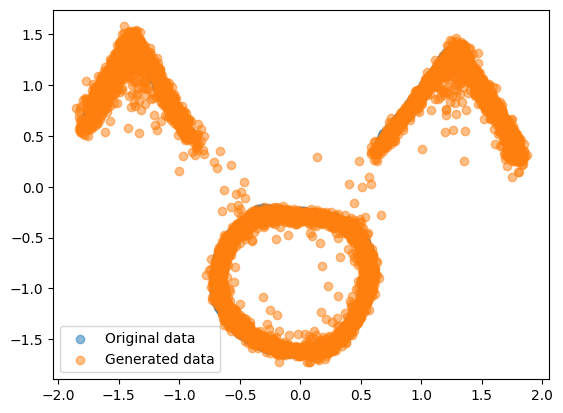

In [24]:
Xgen, Xgen_hist = sample_ddpm(model, 10000, 2) # 10000개의 2차원 가우시안을 이용해서 Denoising 진행
Xgen = Xgen.cpu()
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="o", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.show()

## 결과는?

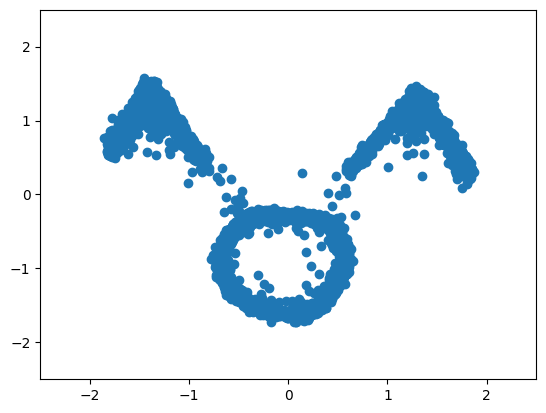

In [25]:
import matplotlib.animation as animation

def draw_frame(i):
    plt.clf()
    Xvis = Xgen_hist[i].cpu()
    fig = plt.scatter(Xvis[:, 0], Xvis[:, 1], marker="o", animated=True)
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.5, 2.5])
    return fig,

fig = plt.figure()
anim = animation.FuncAnimation(fig, draw_frame, frames=diffusion_steps, interval=20, blit=True)
anim.save('emoji_generation.mp4', fps=10)

In [26]:
mp4 = open('/content/emoji_generation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


# Reference
The codes above are based on  
https://github.com/AlexandreNap/Denoising-Diffusion-Probabilistic-Model-toy-project  
https://github.com/albarji/toy-diffusion  
And  
Modified by https://github.com/Pulyong